In [1]:
import pandas as pd
import mc_processor
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import visualizing

import importlib
importlib.reload(mc_processor)
importlib.reload(visualizing)

%matplotlib inline
%config InlineBackend.figure_format = 'png'



In [2]:
survey_year = str(2024)

In [62]:
# read results files

# clarifier = "field2/rvoter/"
clarifier = "stacked/"

codebook = pd.read_csv(os.path.join(survey_year,f'raw/levels_codebook.csv'), encoding='utf-8')
data = pd.read_csv(os.path.join(survey_year,f'raw/{clarifier}data.csv'), encoding='utf-8')
q_codebook = pd.read_csv(os.path.join(survey_year,f'raw/question_codebook.csv'), encoding='utf-8', index_col = 'qid')

# q_codebook into dict
q_codebook = q_codebook.to_dict().get('qidFull')

In [60]:
q_codebook

{'ResponseID': 'NO TEXT',
 'xdemAll': 'NO TEXT',
 'demZIP': 'What is your five-digit ZIP Code?',
 'BPC1_1': 'How often do you seek out the following kinds of information about elections, if at all? --- Information about how to register and vote',
 'BPC1_2': 'How often do you seek out the following kinds of information about elections, if at all? --- Information about how elections are run',
 'BPC1_3': 'How often do you seek out the following kinds of information about elections, if at all? --- Information about who won an election',
 'BPC1_4': 'How often do you seek out the following kinds of information about elections, if at all? --- Information about candidates',
 'BPC1_5': 'How often do you seek out the following kinds of information about elections, if at all? --- News about campaigns',
 'BPC2_1NET': 'Below is a list of sources from which people might get news and information about elections. After reading this list of sources, please choose the three that you use most often to le

In [5]:
nulldata = pd.DataFrame(data.isnull().sum(),columns=["Sum_Null"]) ##2204 rows in 2024
nulldata.sort_values(by=["Sum_Null"],ascending=False,inplace=True)

# nulldata[nulldata["Sum_Null"]>0].head(20)

In [6]:
# all demo categories
for key in q_codebook:
    if "dem" in key:
        print(key)

xdemAll
demZIP
xdemGender
demAgeGeneration
xdemIdeo3
xdemInc3
xdemWhite
xdemHispBin
demBlackBin
demRaceOther
xdemReligion
xdemReligOther
xdemEvang
xdemUsr
xdemEmploy
xdemMilHH1
xdemBidenApprove
xdemBidenApprove2
demInsured
demInsType
demUnion
demLGBTQ1
xdemMarried
BPCxdem1
BPCxdem2
BPCxdem3
BPCxdem4
BPCxdem5
demGender3
demRVoter


In [7]:
##CONFIDENCE RATES

#save individual csvs for confidence by xpid3
confidence_keys = {20:"Your vote",21:"Votes in your local community",22:"Votes in your state",23:"Votes across the country"}

dfs = {}

for i in range(20, 24):
    df = mc_processor.get_confidence_results(data, codebook, q_codebook, question_number=i, demo='xpid3', suppress_output=True)
    dfs[confidence_keys[i]] = df
    df = df.map(lambda x: f"{x:.1%}")
    df.to_csv(f"2024/charts/BPC{i}.csv")


In [8]:
##PLOT OVERALL CONFIDENCE RATES

demo = None
question_number = 20

dfs = []
cols = []
for i in range(20,24):
    dfs.append(mc_processor.get_confidence_results(data,codebook,q_codebook,i,demo=None,suppress_output=True))#.map(lambda x: f"{x:.1%}"))
    cols.append(q_codebook[f"BPC{i}a"])

confidence = pd.concat(dfs, axis=1)
confidence.columns = cols

# visualizing.plot_overall_confidence(confidence)

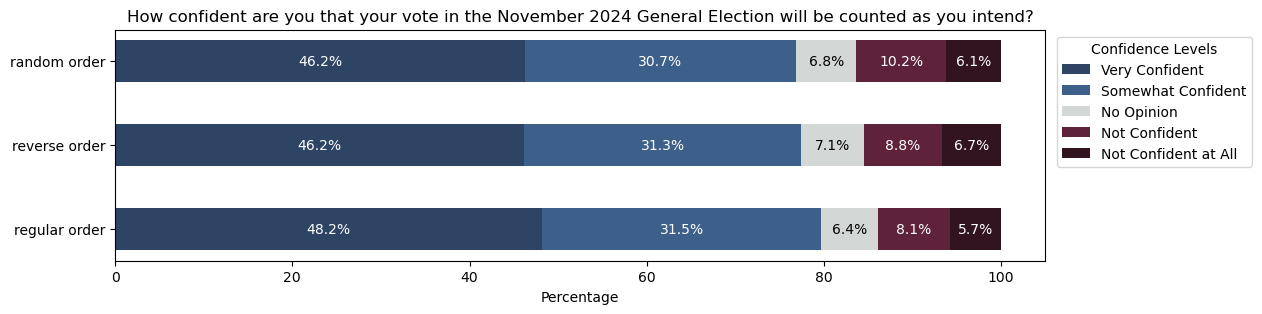

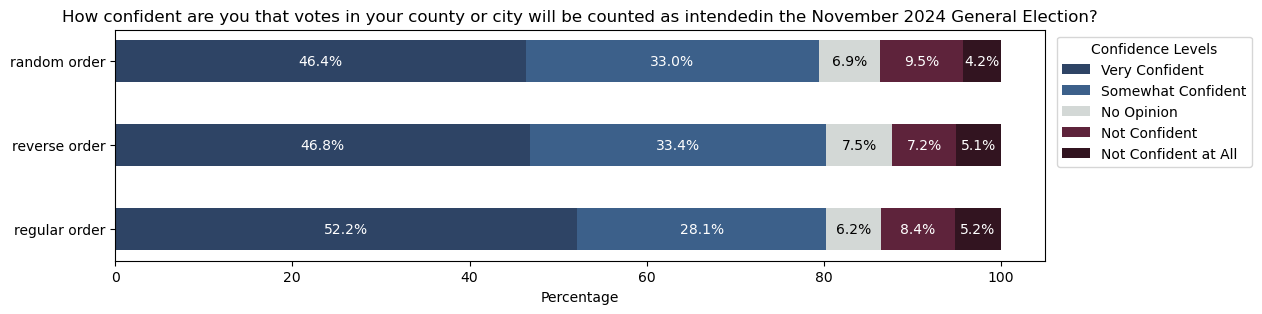

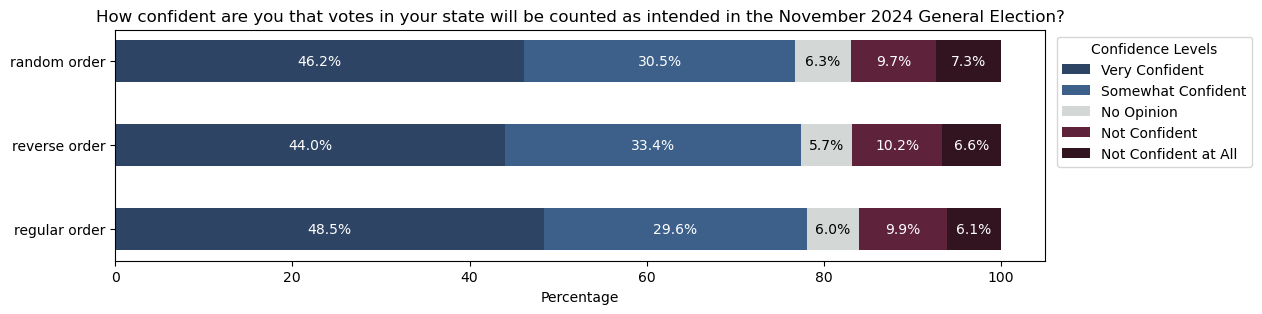

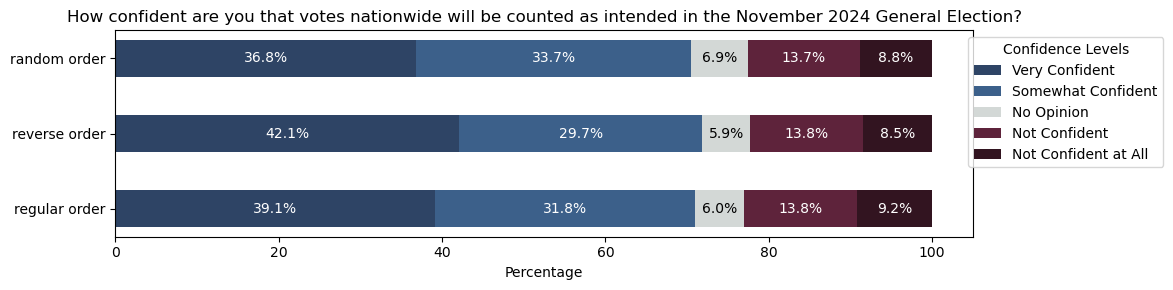

In [9]:
##PLOT CONFIDENCE SPLIT SAMPLES
#split sample a - regular order
#split sample b - reverse order
#split sample c - random order

sample_dict = {"a":"regular order","b":"reverse order","c":"random order"}

all_dfs = []

for i in range(20,24):
    # store dfs for each sample
    q_dfs = []    
    for split_sample in ["a","b","c"]:
        question = "BPC"+str(i)+split_sample
    
        # get results for question by sample
        df = mc_processor.run_and_display(data,codebook,q_codebook,question,survey_year,demo=None,suppress_output=True)
        df.columns = [f"{sample_dict[split_sample]}"]
        q_dfs.append(df)
    
    # print(q_codebook[question]) # defaults to split sample c, but tested with other a/b/c combos and got same result (they rotated question order but didn't change question #)
    

    q_df = pd.concat(q_dfs, axis=1)

    q_df["deviation"] = q_df.std(axis=1)

    ## display df with formatted percents
    # display(q_df.iloc[:,0:3].map(lambda x: f"{x:.1%}"))

    all_dfs.append(q_df)

visualizing.plot_split_sample(all_dfs, q_codebook)

# # get n for split samples
# for sample in ["a","b","c"]:
#     # for q in range(20,24):
#     q = 20
#     print(data[[f"BPC{q}{sample}"]].count())

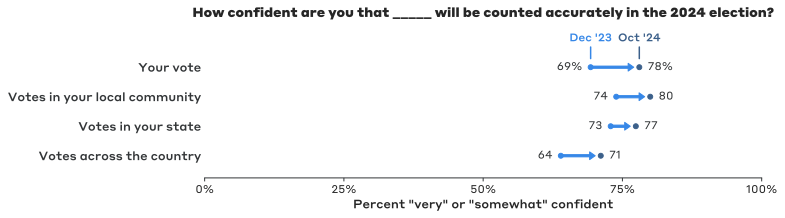

In [52]:
##DOT PLOT CHANGE IN CONFIDENCE 23 -> 24

importlib.reload(visualizing)

confidence2024 = confidence
confidence2023 = pd.read_csv("2023/confidence.csv",index_col=0)

# cols
confidence2023.columns = list(confidence_keys.values())
confidence2024.columns = list(confidence_keys.values())


confidence_23_24 = []
dfs= [confidence2023,confidence2024]
years  = ["2023","2024"]
for i in range(2):
    df = dfs[i].T
    df[years[i]] = df[["Very confident","Somewhat confident"]].sum(axis=1)
    df = df[[years[i]]]
    confidence_23_24.append(df)

confidence_23_24 = pd.concat(confidence_23_24,axis=1)

%config InlineBackend.figure_format = 'svg'

importlib.reload(visualizing)
visualizing.dotplot2(confidence_23_24,
                     'confidence_23_24.png',
                     start_tick_title = "Dec '23",
                     end_tick_title = "Oct '24",
                     xlabel='Percent "very" or "somewhat" confident',
                     title='How confident are you that _____ will be counted accurately in the 2024 election?')


In [12]:
# store demo results in processed folder
demos = ['xpid3','age']
questions = [f"BPC{i}" for i in range(1, 20)] + ['BPC24']

for demo in demos:
     for question in questions:
          mc_processor.run_and_display(data,codebook,q_codebook,question,survey_year,demo,suppress_output=True)

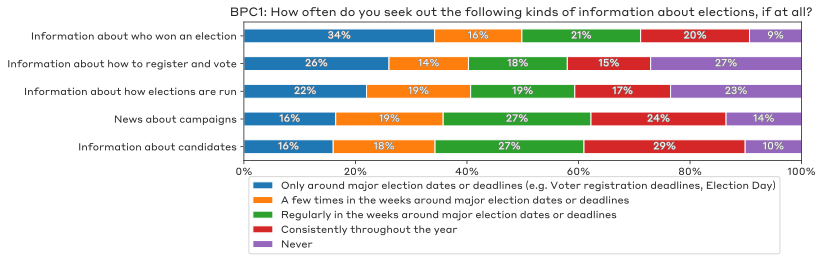

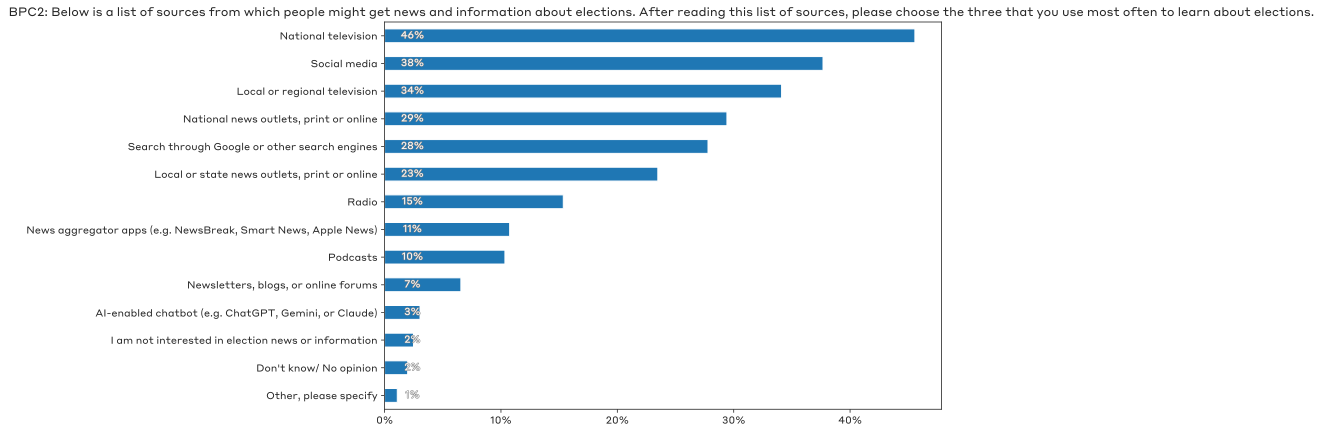

In [13]:
demo = None

questions = [f"BPC{i}" for i in range(1, 3)]

for question in questions:
     df = mc_processor.run_and_display(data,codebook,q_codebook,question,survey_year,demo,suppress_output=False)

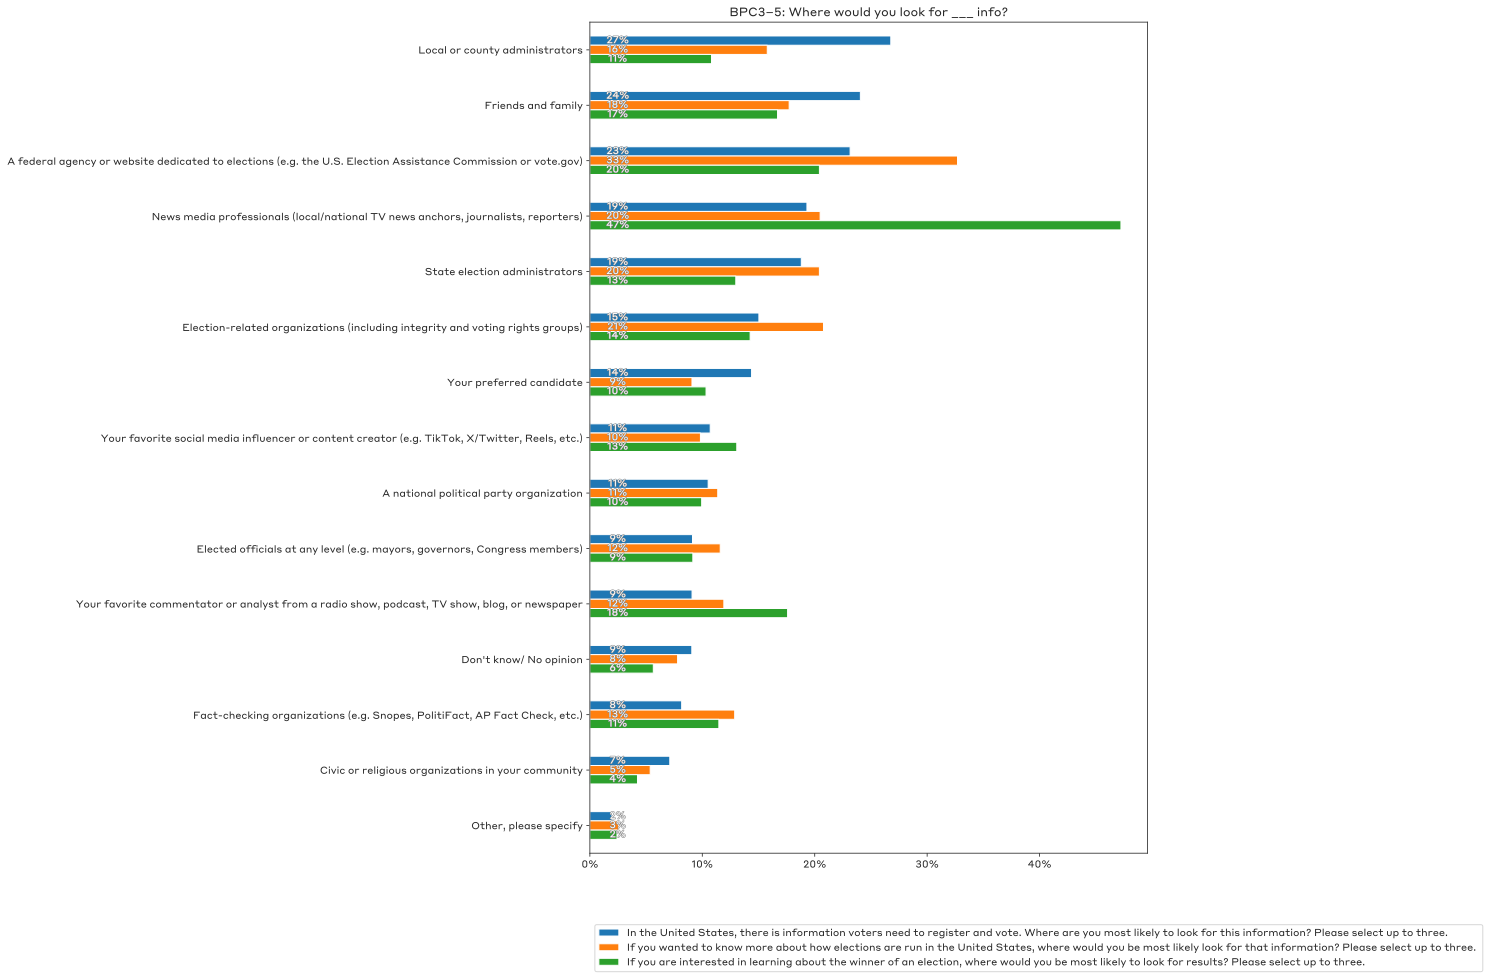

In [64]:
questions = [f"BPC{j}" for j in range(3, 6)]

final_df = mc_processor.get_parallel_questions(data, codebook, q_codebook, questions, survey_year)
ax = visualizing.plot_question(final_df, 'BPC3–5', 'Where would you look for ___ info?')

final_df = final_df.sort_values(by=final_df.columns[0],ascending=False).map(lambda x: f"{x:.1%}")
# display(final_df)
final_df.to_csv("2024/charts/info_topthree.csv")

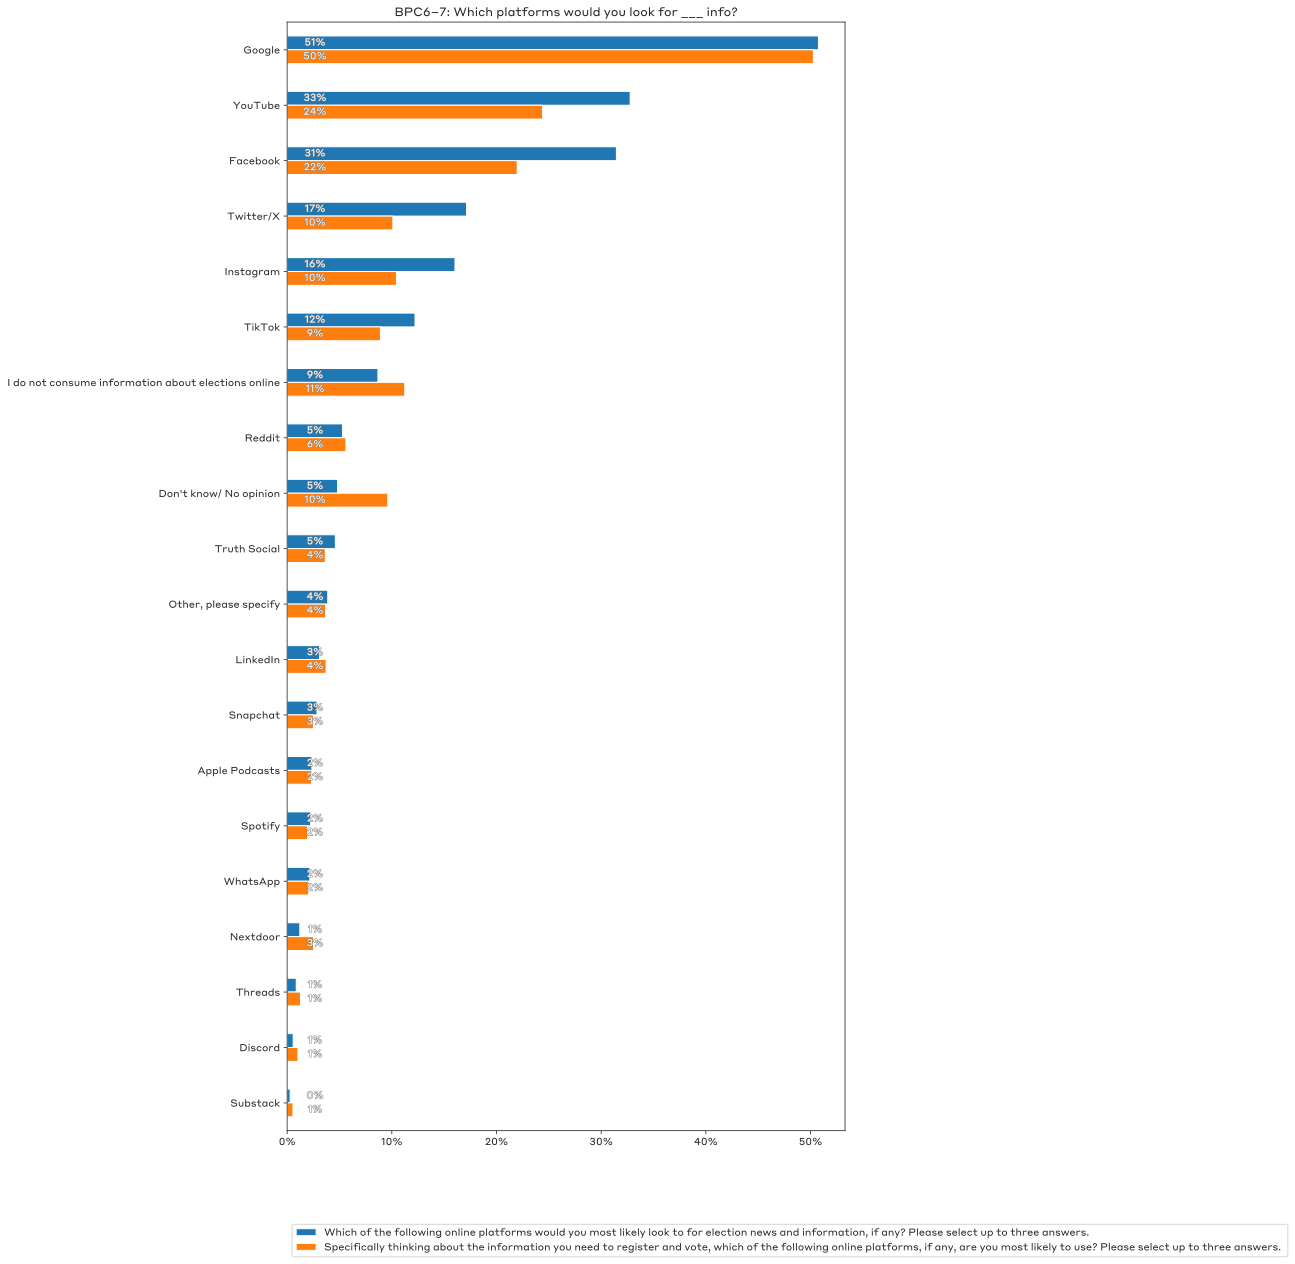

In [15]:
questions = [f"BPC{j}" for j in range(6, 8)]

final_df = mc_processor.get_parallel_questions(data, codebook, q_codebook, questions, survey_year)

ax = visualizing.plot_question(final_df, 'BPC6–7', 'Which platforms would you look for ___ info?')

final_df = final_df.sort_values(by=final_df.columns[0],ascending=False).map(lambda x: f"{x:.1%}")
# display(final_df)
final_df.to_csv("2024/charts/online_platforms.csv")

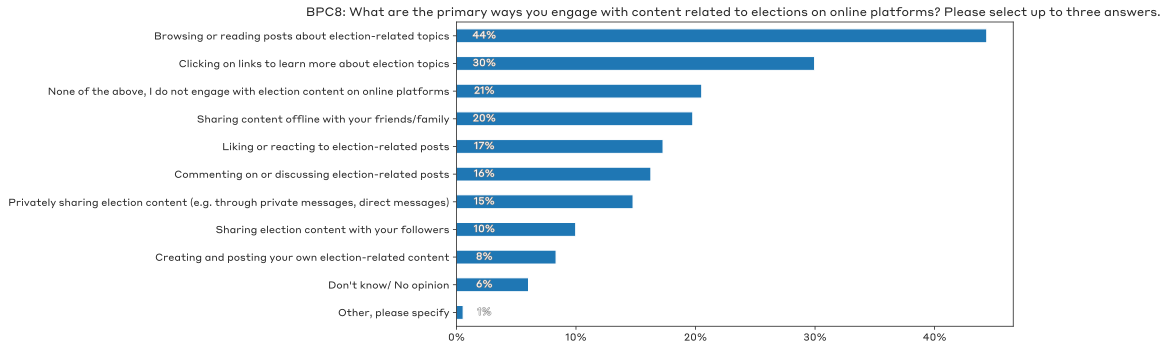

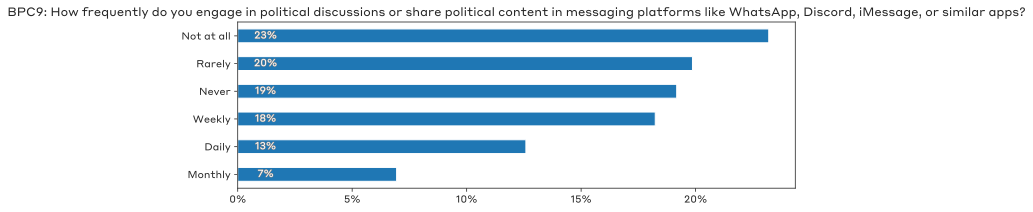

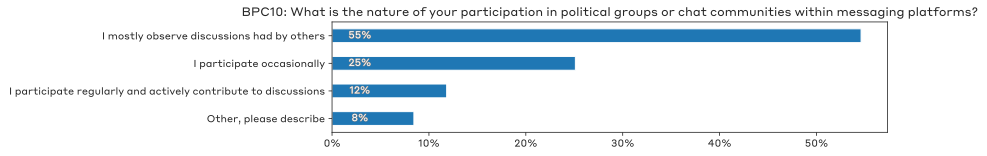

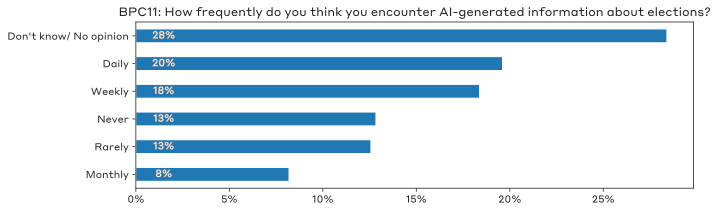

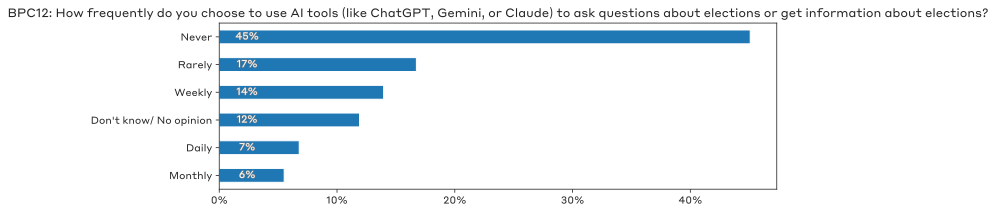

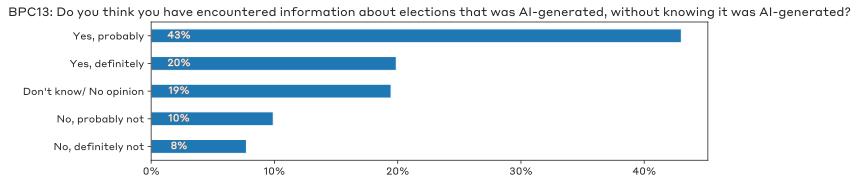

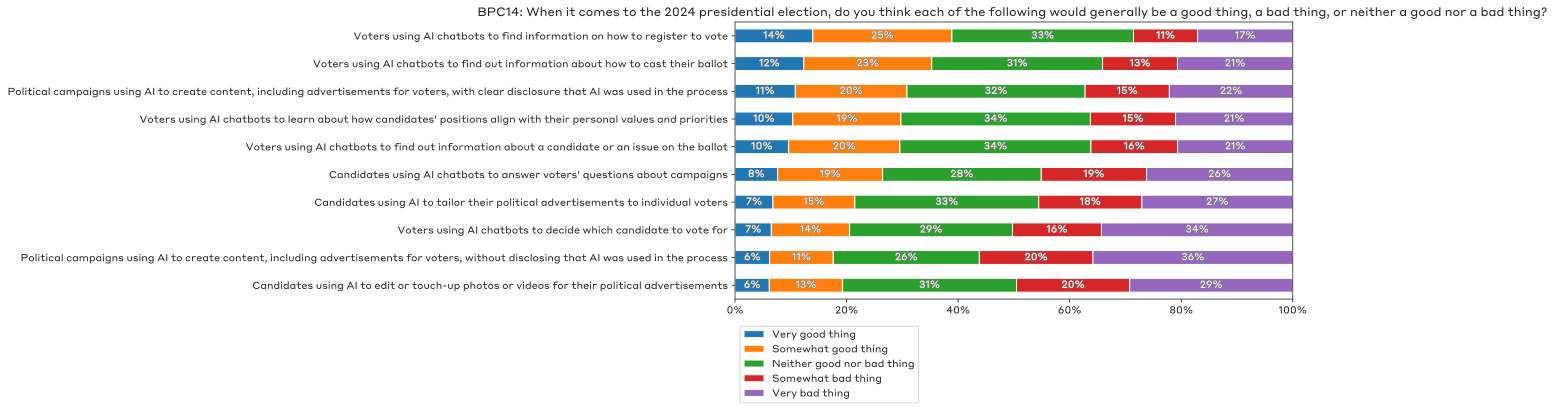

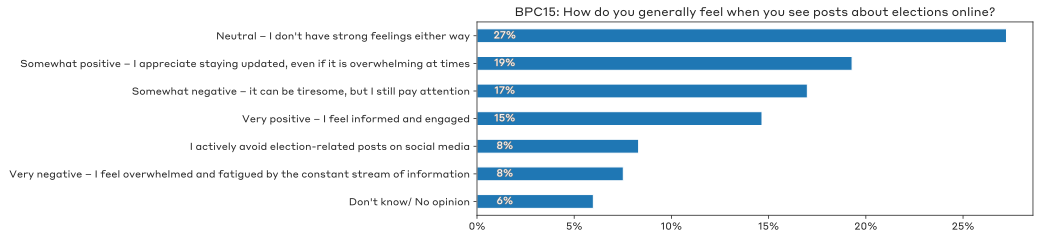

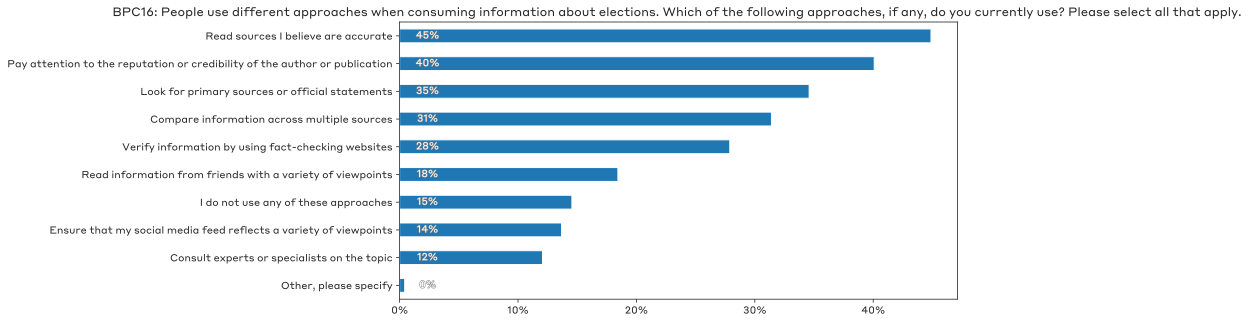

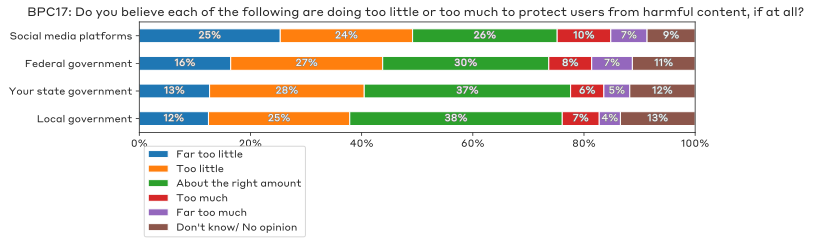

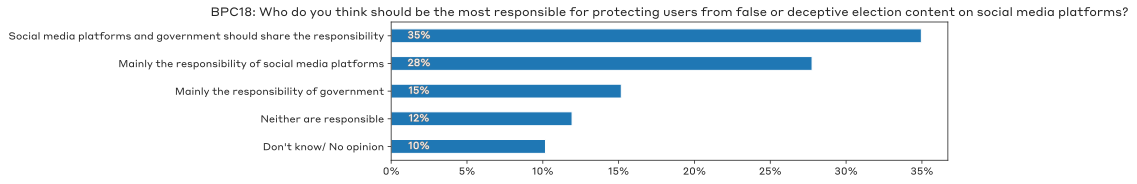

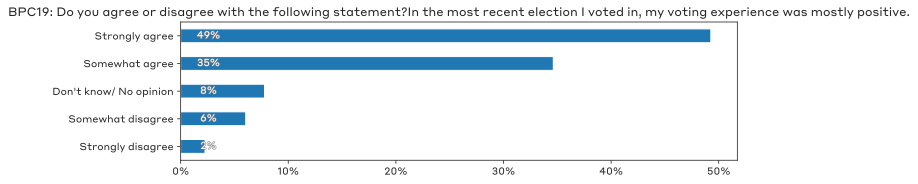

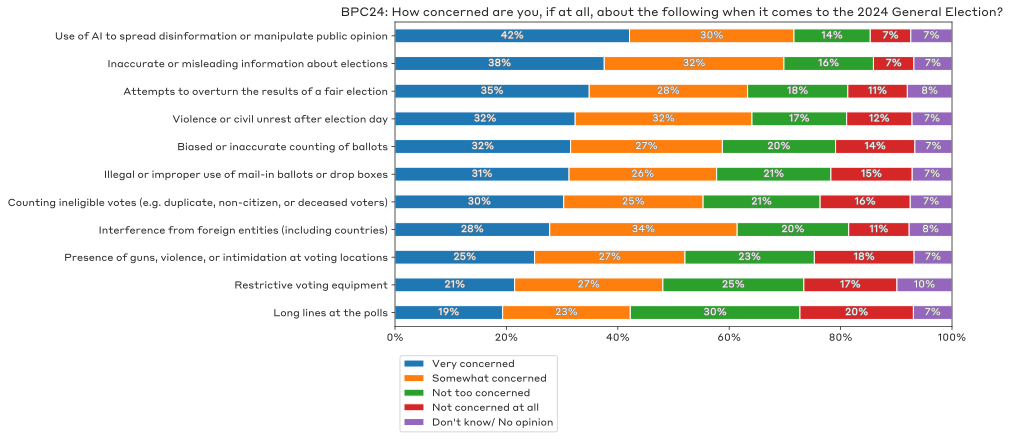

In [16]:
questions = [f"BPC{i}" for i in range(8, 20)] + ['BPC24']

for question in questions:
     df = mc_processor.run_and_display(data,codebook,q_codebook,question,survey_year,demo,suppress_output=False)


# Single use code / misc

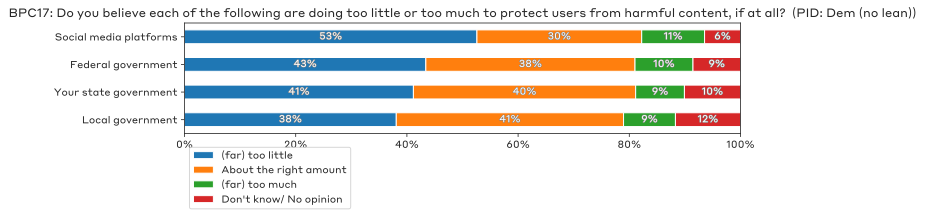

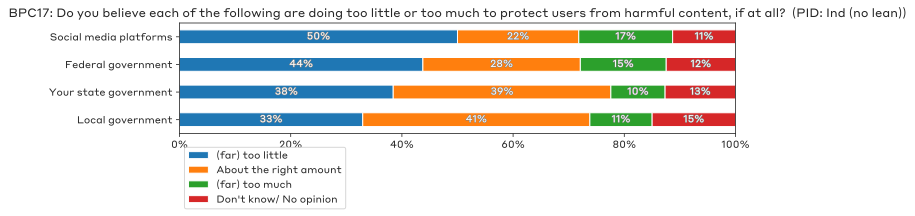

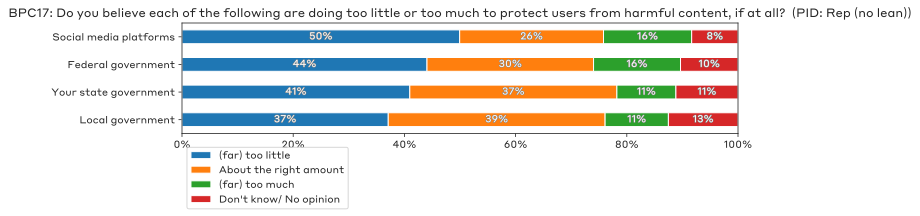

In [154]:
# combine "too little" and "far too little" and "too much" and "far too much"
q = 'BPC17'
df = mc_processor.run_and_display(data,codebook,q_codebook,"BPC17",demo="xpid3",survey_year=survey_year,suppress_output=True, sort=False)
df = df.T
combined_little = '(far) too little'
combined_much = '(far) too much'
df[combined_little] = df['Too little'] + df['Far too little']
df[combined_much] = df['Too much'] + df['Far too much']
# df.columns = df.columns[[-2, 2, -1, 5]]
df = df.drop(columns=['Far too little', 'Too little', 'Too much', 'Far too much'])
df = df[[combined_little, 'About the right amount', combined_much, "Don't know/ No opinion"]]

for party in parties:
    visualizing.plot_question(df.loc[party], q, f"{mc_processor.get_question_text(q_codebook, q)} ({party})")

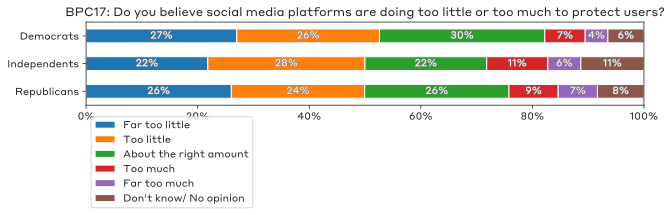

<Axes: title={'center': 'BPC17: Do you believe social media platforms are doing too little or too much to protect users?'}>

In [175]:
df = mc_processor.run_and_display(data,codebook,q_codebook,"BPC17",demo="xpid3",survey_year=survey_year,suppress_output=True, sort=False)
df = df.T
idx = pd.IndexSlice
df = df.loc[idx[:, 'Social media platforms'], :]


df = df.droplevel(1)

df.index = ['Democrats', 'Independents', 'Republicans']
# df

visualizing.plot_question(df, 'BPC17', 'Do you believe social media platforms are doing too little or too much to protect users?', sort=False)

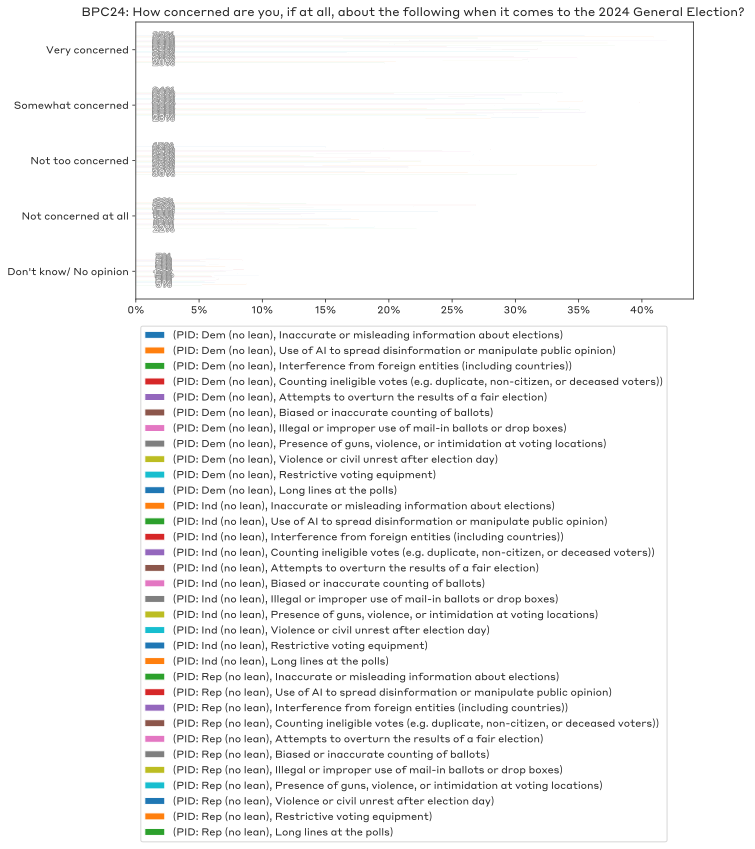

In [54]:
df = mc_processor.run_and_display(data,codebook,q_codebook,question,survey_year,demo='xpid3',suppress_output=True)


In [35]:
# feelings23 = pd.read_csv("2023/feelings.csv",index_col=0)
# feelings23.index = [i.replace("it's", "it is").replace("/n", "/ N").replace("Somewhat negative– It","Somewhat negative – it") for i in feelings23.index]
# feelings23.columns = ["2023"]
# feelings = mc_processor.run_and_display(data,codebook,q_codebook,"BPC15",survey_year,demo,suppress_output=True)
# feelings = pd.concat([feelings23,feelings],axis=1)

# visualizing.dotplot(feelings,"feelings",start_tick_title="Dec' 23",end_tick_title="Oct' 24",xlabel="Percent of Respondents")

# ## stopped working on this one -- adjusting axes messes up other formatting, needs some more attention
# # don't think it's the best visual anyways -- want to consider something different

In [36]:
# ### VISUALIZE CONFIDENCE BY DEMO

# confidence_keys = {20:"Your vote",21:"Votes in your local community",22:"Votes in your state",23:"Votes across the country"}

# dfs = {}

# for i in range(20, 24):
#     df = mc_processor.get_confidence_results(data, codebook, q_codebook, question_number=i, demo='xpid3', suppress_output=True)
#     dfs[confidence_keys[i]] = df

# demo_confidence = []
# for q in dfs:
#     df = dfs[q].T
#     demo_confidence.append(pd.DataFrame(df[["Very confident","Somewhat confident"]].sum(axis=1),columns=[q]))

# demo_confidence = pd.concat(demo_confidence,axis=1)
    
# demo_confidence =demo_confidence.T
# demo_confidence = demo_confidence.map(lambda x: f"{x:.1%}")
# # demo_confidence.to_csv("2024/charts/xpid_confidence.csv")

# # bpc colors
# bpc_blue = '#3C608A'
# bpc_lightgray = '#d3d8d6'
# bpc_darkgray = '#333638'
# bpc_red = '#e43e47'
# bpc_lightblue = '#3687e7'
# bpc_lightyellow = '#f6fbc2'
# bpc_lightpurple = '#ddafec'
# bpc_pink='#f87fab'
# bpc_orange='#eec044'

# # Function to add data labels to bars
# def add_labels(bars):
#     for bar in bars:
#         width = bar.get_width()
#         ax.text(width, bar.get_y() + bar.get_height() / 2, f'{width * 100:.0f}%', ha='left', va='center')

# # Set up the plot
# fig, ax = plt.subplots(figsize=(10, 6))

# # Define the positions for each bar
# bar_height = 0.2
# index = np.arange(len(demo_confidence))

# # Plot each group of bars
# bar1 = ax.barh(index - bar_height * 1.5, demo_confidence['PID: Dem (no lean)'], bar_height, label='PID: Dem (no lean)', color=bpc_blue)
# bar2 = ax.barh(index - bar_height / 2, demo_confidence['PID: Ind (no lean)'], bar_height, label='PID: Ind (no lean)', color=bpc_lightgray)
# bar3 = ax.barh(index + bar_height / 2, demo_confidence['PID: Rep (no lean)'], bar_height, label='PID: Rep (no lean)', color=bpc_red)
# bar4 = ax.barh(index + bar_height * 1.5, demo_confidence['overall'], bar_height, label='Overall', color=bpc_pink)

# # Call the function for each set of bars
# add_labels(bar1)
# add_labels(bar2)
# add_labels(bar3)
# add_labels(bar4)

# # Add labels and title
# ax.set_ylabel('Vote Confidence')
# ax.set_xlabel('Percentage (%)')
# ax.set_title('Confidence in Voting by Political ID')
# ax.set_yticks(index)
# ax.set_yticklabels(demo_confidence.index)

# # Add a legend
# ax.legend()

# # Display the plot
# plt.savefig("confidence_xpid.png")
# plt.show()